<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Longitudinal Prediction**

Can we use previous year's data and compoundingly predict suicide risk?

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

___________

### **Helper Functions**

In [3]:
def get_yearly_columns(base_cols, years):
    return [f"{col}{year}" for col in base_cols for year in years]

In [4]:
def get_encoded_columns(df, variables):
    cols = set()
    for var in variables:
        cs = df.filter(regex=fr"^{var}.+").columns.tolist()
        for c in cs:
            match = re.search(r"(.+)(\d{4})", c)
            if match:
                c_name, _ = match.groups()
                cols.add(c_name)
    return cols

___________

### **Data**

In [5]:
cohorts = range(2023, 2027)
years = range(2020, 2024)

In [6]:
# Read formatted linked persons
final23 = pd.read_csv("processed/final23.csv")
final24 = pd.read_csv("processed/final24.csv")
final25 = pd.read_csv("processed/final25.csv")
final26 = pd.read_csv("processed/final26.csv")
all_linked = pd.concat([final23, final24, final25, final26], ignore_index=True, axis=0)

final = {
    2023: final23,
    2024: final24,
    2025: final25,
    2026: final26,
}

In [7]:
# Read encoded linked persons
encoded23 = pd.read_csv("encoded/encoded23.csv")
encoded24 = pd.read_csv("encoded/encoded24.csv")
encoded25 = pd.read_csv("encoded/encoded25.csv")
encoded26 = pd.read_csv("encoded/encoded26.csv")

In [8]:
for year in years:
    final23[f"HasResponse{year}"] = final23[f"HasResponse{year}"].replace(-1, 0)
    encoded23[f"HasResponse{year}"] = encoded23[f"HasResponse{year}"].replace(-1, 0)

________

In [9]:
# Questions sorted by categorical, ordinal, and quantitative

ordinal_cols = {
    "INV.DBL.APSS.Q1.MindReading",
    "INV.DBL.APSS.Q2.TVRadio",
    "INV.DBL.APSS.Q3.Spying",
    "INV.DBL.APSS.Q4.Auditory",
    "INV.DBL.APSS.Q5.Controlled",
    "INV.DBL.APSS.Q6.Visual",
    "INV.DBL.APSS.Q7.Grandiosity",
    "INV.INT.ERS.Q01.Persistence1",
    "INV.INT.ERS.Q02.Sensitivity1",
    "INV.INT.ERS.Q03.IntensityArousal1",
    "INV.INT.ERS.Q04.IntensityArousal2",
    "INV.INT.ERS.Q05.Sensitivity2",
    "INV.INT.ERS.Q06.IntensityArousal3",
    "INV.INT.ERS.Q07.Sensitivity3",
    "INV.INT.ERS.Q08.Persistence2",
    "INV.INT.ERS.Q09.Sensitivity4",
    "INV.INT.ERS.Q10.Persistence3",
    "INV.INT.ERS.Q11.Persistence4",
    "INV.INT.ERS.Q12.Sensitivity5",
    "INV.INT.ERS.Q13.Sensitivity6",
    "INV.INT.ERS.Q14.Sensitivity7",
    "INV.INT.ERS.Q15.Sensitivity8",
    "INV.INT.ERS.Q16.Sensitivity9",
    "INV.INT.ERS.Q17.IntensityArousal4",
    "INV.INT.ERS.Q18.Sensitivity10",
    "INV.INT.ERS.Q19.IntensityArousal5",
    "INV.INT.ERS.Q20.IntensityArousal6",
    "INV.INT.ERS.Q21.IntensityArousal7",
    "INV.INT.PHQ4.Q1.Anxious",
    "INV.INT.PHQ4.Q2.Worried",
    "INV.INT.PHQ4.Q3.Depressed",
    "INV.INT.PHQ4.Q4.Anhedonia",
    "INV.INT.SUB.Alcohol.Past30",
    "INV.INT.SUB.Cannabis.Past30",
    "INV.INT.SUB.Cigarettes.Past30",
    "INV.INT.SUB.Cigars.Past30",
    "INV.INT.SUB.Smokeless.Past30",
    "INV.INT.SUB.Vapes.Past30",
}

quant_cols = {
    "INV.DBL.APSS.Total",
    "INV.INT.ERS.IntensityArousalTotal",
    "INV.INT.ERS.PersistenceTotal",
    "INV.INT.ERS.SensitivityTotal",
    "INV.INT.ERS.Total",
    "INV.INT.PHQ4.Anxiety",
    "INV.INT.PHQ4.Depression",
    "INV.INT.PHQ4.Total",
}

cat_cols = {
    "INV.LGL.PHQ4.Anxiety",
    "INV.LGL.PHQ4.Depression",
    "INV.INT.SI.Attempt",
    "INV.INT.SI.How",
    "INV.INT.SI.Selfharm",
    "INV.INT.SI.Thoughts",
    "INV.LGL.SUB.Alcohol.Life",
    "INV.LGL.SUB.Cannabis.Life",
    "INV.LGL.SUB.Cigarettes.Life",
    "INV.LGL.SUB.Cigars.Life",
    "INV.LGL.SUB.Smokeless.Life",
    "INV.LGL.SUB.Vapes.Life",
    "INV.LGL.HelpSeeking0",
    "INV.LGL.HelpSeeking1",
    "INV.LGL.HelpSeeking2",
    "INV.LGL.HelpSeeking3",
    "INV.LGL.HelpSeeking4",
    "INV.LGL.HelpSeeking5",
    "INV.LGL.HelpSeeking6",
    "INV.LGL.HelpSeeking7",
    "INV.LGL.HelpSeeking8",
    "INV.LGL.HelpSeeking9",
    "INV.LGL.HelpSeeking10",
    "INV.LGL.HelpSeeking11",
    "INV.LGL.HelpSeeking12",
    "INV.LGL.HelpSeeking13",
    "SBJ.FCT.Ethnicity",
    "SBJ.FCT.GenderId",
    "SBJ.FCT.Sex",
    "SBJ.FCT.Sexuality",
    "SBJ.LGL.Race.AmericanIndianAlaskaNative",
    "SBJ.LGL.Race.Asian",
    "SBJ.LGL.Race.HaitianBlackAfricanAmerican",
    "SBJ.LGL.Race.HawaiianPacificIslander",
    "SBJ.LGL.Race.MiddleEasternNorthAfrican",
    "SBJ.LGL.Race.White",
    "SBJ.LGL.Race.Multiple",
}

In [10]:
# All common questions across years

# Survey
survey = [
    "Unnamed: 0",
    "IDX.INT.Origin.Database",
    "IDX.INT.Origin.Record",
    "SSS.INT.SurveyYear",
    "IDX.INT.Row",
    "IDX.CHR.Linked.ID",
    "QCC.LGC.Linked.Attempted",
    "QCC.LGC.Linked",
    "QCC.LGC.Linked.No_issues",
    "QCC.CHR.Linked.Score.Base",
    "QCC.CHR.Linked.Score.Add",
    "QCC.CHR.Linked.Rows",
    "QCC.CHR.Linked.Dissimilarity",
]
   
# Adolescent Psychotic-like Symptoms 
psychotic = [
    "INV.DBL.APSS.Q1.MindReading",
    "INV.DBL.APSS.Q2.TVRadio",
    "INV.DBL.APSS.Q3.Spying",
    "INV.DBL.APSS.Q4.Auditory",
    "INV.DBL.APSS.Q5.Controlled",
    "INV.DBL.APSS.Q6.Visual",
    "INV.DBL.APSS.Q7.Grandiosity",
    "INV.DBL.APSS.Total",
]
    
# Emotional Reactivity 
emotional = [
    "INV.INT.ERS.IntensityArousalTotal",
    "INV.INT.ERS.PersistenceTotal",
    "INV.INT.ERS.Q01.Persistence1",
    "INV.INT.ERS.Q02.Sensitivity1",
    "INV.INT.ERS.Q03.IntensityArousal1",
    "INV.INT.ERS.Q04.IntensityArousal2",
    "INV.INT.ERS.Q05.Sensitivity2",
    "INV.INT.ERS.Q06.IntensityArousal3",
    "INV.INT.ERS.Q07.Sensitivity3",
    "INV.INT.ERS.Q08.Persistence2",
    "INV.INT.ERS.Q09.Sensitivity4",
    "INV.INT.ERS.Q10.Persistence3",
    "INV.INT.ERS.Q11.Persistence4",
    "INV.INT.ERS.Q12.Sensitivity5",
    "INV.INT.ERS.Q13.Sensitivity6",
    "INV.INT.ERS.Q14.Sensitivity7",
    "INV.INT.ERS.Q15.Sensitivity8",
    "INV.INT.ERS.Q16.Sensitivity9",
    "INV.INT.ERS.Q17.IntensityArousal4",
    "INV.INT.ERS.Q18.Sensitivity10",
    "INV.INT.ERS.Q19.IntensityArousal5",
    "INV.INT.ERS.Q20.IntensityArousal6",
    "INV.INT.ERS.Q21.IntensityArousal7",
    "INV.INT.ERS.SensitivityTotal",
    "INV.INT.ERS.Total",
]
    
# PHQ4
phq4 = [
    "INV.INT.PHQ4.Anxiety",
    "INV.INT.PHQ4.Depression",
    "INV.INT.PHQ4.Q1.Anxious",
    "INV.INT.PHQ4.Q2.Worried",
    "INV.INT.PHQ4.Q3.Depressed",
    "INV.INT.PHQ4.Q4.Anhedonia",
    "INV.INT.PHQ4.Total",
    "INV.LGL.PHQ4.Anxiety",
    "INV.LGL.PHQ4.Depression",
    # "INV.FCT.PHQ4.Total",
]
    
# Suicidality
suicide = [
    "INV.INT.SI.Attempt",
    "INV.INT.SI.How",
    "INV.INT.SI.Selfharm",
    "INV.INT.SI.Thoughts",
]
    
# Substance Use
substance = [
    "INV.INT.SUB.Alcohol.Past30",
    "INV.INT.SUB.Cannabis.Past30",
    "INV.INT.SUB.Cigarettes.Past30",
    "INV.INT.SUB.Cigars.Past30",
    "INV.INT.SUB.Smokeless.Past30",
    "INV.INT.SUB.Vapes.Past30",
    
    "INV.LGL.SUB.Alcohol.Life",
    "INV.LGL.SUB.Cannabis.Life",
    "INV.LGL.SUB.Cigarettes.Life",
    "INV.LGL.SUB.Cigars.Life",
    "INV.LGL.SUB.Smokeless.Life",
    "INV.LGL.SUB.Vapes.Life",
]
    
# Help Seeking
help = [
    "INV.LGL.HelpSeeking0",
    "INV.LGL.HelpSeeking1",
    "INV.LGL.HelpSeeking2",
    "INV.LGL.HelpSeeking3",
    "INV.LGL.HelpSeeking4",
    "INV.LGL.HelpSeeking5",
    "INV.LGL.HelpSeeking6",
    "INV.LGL.HelpSeeking7",
    "INV.LGL.HelpSeeking8",
    "INV.LGL.HelpSeeking9",
    "INV.LGL.HelpSeeking10",
    "INV.LGL.HelpSeeking11",
    "INV.LGL.HelpSeeking12",
    "INV.LGL.HelpSeeking13",
    # "INV.CHR.HelpSeeking.Other",
]
    
# Identity
identity = [
    # "SBJ.CHR.Gender.Other",
    # "SBJ.CHR.Link.Streetname",
    # "SBJ.CHR.SexualOrientation.Other",
    "SBJ.FCT.Ethnicity",
    "SBJ.FCT.GenderId",
    # "SBJ.FCT.Link.BirthMonth",
    # "SBJ.FCT.Link.EyeColor",
    # "SBJ.FCT.Link.MiddleInitial",
    # "SBJ.FCT.Link.OlderSiblings",
    # "SBJ.FCT.Race",
    "SBJ.FCT.Sex",
    "SBJ.FCT.Sexuality",
    # "SBJ.INT.Link.KindergartenYearEst",
    "SBJ.LGL.Race.AmericanIndianAlaskaNative",
    "SBJ.LGL.Race.Asian",
    "SBJ.LGL.Race.HaitianBlackAfricanAmerican",
    "SBJ.LGL.Race.HawaiianPacificIslander",
    "SBJ.LGL.Race.MiddleEasternNorthAfrican",
    "SBJ.LGL.Race.Multiple",
    # "SBJ.LGL.Race.Other",
    "SBJ.LGL.Race.White",
]
    
# School
school = [
    "SSS.CHR.GradesSurveyed",
    "SSS.DBL.PercentOptOutsbyGrades",
    "SSS.DBL.PercentOptOutsbySchool",
    "SSS.INT.Cohort",
    "SSS.INT.District.Code",
    "SSS.INT.Eighth.Grade.Enrollment",
    "SSS.INT.Eleventh.Grade.Enrollment",
    "SSS.INT.Fifth.Grade.Enrollment",
    "SSS.INT.Grade",
    "SSS.INT.Ninth.Grade.Enrollment",
    "SSS.INT.School.Code",
    "SSS.INT.Seventh.Grade.Enrollment",
    "SSS.INT.Sixth.Grade.Enrollment",
    "SSS.INT.Tenth.Grade.Enrollment",
    "SSS.INT.Time_point",
    "SSS.INT.Twelfth.Grade.Enrollment",
]

all_qs = psychotic + help + suicide + school + identity + substance + phq4

In [11]:
psychotic_e = get_encoded_columns(encoded23, psychotic)
emotional_e = get_encoded_columns(encoded23, emotional)
phq4_e = get_encoded_columns(encoded23, phq4)
suicide_e = get_encoded_columns(encoded23, suicide)
substance_e = get_encoded_columns(encoded23, substance)
help_e = get_encoded_columns(encoded23, help)
identity_e = get_encoded_columns(encoded23, identity)

In [12]:
cats = {
    "regular": {
        "psychotic": psychotic,
        "emotional": emotional,
        "phq4": phq4,
        "suicide": suicide,
        "substance": substance,
        "help": help,
        "identity": identity,
    },
    "encoded": {
        "psychotic": psychotic_e,
        "emotional": emotional_e,
        "phq4": phq4_e,
        "suicide": suicide_e,
        "substance": substance_e,
        "help": help_e,
        "identity": identity_e,
    }
}

In [13]:
# `encoded` should be a string: "regular" or "encoded"
def get_cols(y_year, outcome, qs, encoded, prev):
    target_col= f"INV.INT.SI.{outcome}_1.0{y_year}" if encoded == "encoded" else f"INV.INT.SI.{outcome}{y_year}"
    
    feature_cols = []
    for q in qs:
        if q != "suicide":
            feature_cols += get_yearly_columns(cats[encoded][q], [y_year])
        if prev:
            feature_cols += get_yearly_columns(cats[encoded][q], [y_year-1])
    
    return feature_cols, target_col

In [14]:
# Just previous year and curr year
def year_one_prediction_data(df, pred_year):
    df = df[df[f"HasResponse{pred_year}"] == 1]
    df = df[df[f"HasResponse{pred_year + 1}"] == 1]
    
    df = df.filter(regex=fr".*({pred_year}|{pred_year + 1})$", axis=1)
    
    df.rename(columns=lambda col: re.sub(fr"{pred_year}$", "0", col), inplace=True)
    df.rename(columns=lambda col: re.sub(fr"{pred_year + 1}$", "1", col), inplace=True)
    
    return df

In [15]:
# Training data for prev_imputation models
df_2022_2023 = year_one_prediction_data(encoded23, 2022)
df_2021_2022 = year_one_prediction_data(encoded23, 2021)
df_one_year  = pd.concat([df_2022_2023,df_2021_2022],ignore_index=True)

In [16]:
def curr_year_prediction_data(df, curr_year):
    df = df[df[f"HasResponse{curr_year}"] == 1]
    df = df.filter(regex=fr".*({curr_year})$", axis=1)
    df.rename(columns=lambda col: re.sub(fr"{curr_year}$", "1", col), inplace=True)
    return df

In [17]:
# Training data for curr_imputation models
df_2022 = curr_year_prediction_data(encoded23, 2022)
df_2023 = curr_year_prediction_data(encoded23, 2023)
df_curr  = pd.concat([df_2022, df_2023], ignore_index=True)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Rational**

What variables are actually important/have significance in our prediction model?

In [18]:
def plot_conditioned_vars(df, explore_qs, condition_q):
    filtered_df = df[df[condition_q] != -1]
    
    num_plots = len(explore_qs)
    num_cols = 4
    num_rows = math.ceil(num_plots / num_cols) 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows)) 
    axes = axes.flatten()

    for i, explore_q in enumerate(explore_qs):
        if explore_q == condition_q:
            continue
        
        filtered_df = filtered_df[filtered_df[explore_q] != -1]
        
        num_categories = len(set(filtered_df[explore_q]))
        if num_categories <= 3:
            count_df = filtered_df.groupby([condition_q, explore_q]).size().reset_index(name="Count")
            count_df["Proportion"] = count_df.groupby(condition_q)["Count"].transform(lambda x: x / x.sum())
            
            sns.barplot(
                x=condition_q, y="Proportion", hue=explore_q,
                data=count_df, palette=["lightcoral", "lightblue"], ax=axes[i]
            )
            axes[i].set_title(f"{explore_q}", fontsize=14)
            axes[i].set_xlabel(condition_q, fontsize=12)
            axes[i].set_ylabel("Proportion", fontsize=12)
            axes[i].set_ylim((0, 1))
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title=explore_q)
        else:
            sns.histplot(
                data=filtered_df, x=explore_q, hue=condition_q, bins=num_categories, kde=True, 
                stat="density", element="step", common_norm=False, ax=axes[i], palette=["lightcoral", "lightblue"]
            )
            axes[i].set_title(f"{explore_q}", fontsize=14)
            axes[i].set_xlabel(explore_q, fontsize=12)
            axes[i].set_ylabel("Frequency", fontsize=12)
            axes[i].legend(title=condition_q)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout() 
    plt.show()

In [19]:
"""
Uncomment the following code to distributions of variables conditioning on a specific suicidality question!
"""
# question = "Selfharm"
# category = suicide

# plot_conditioned_vars(final23, get_yearly_columns(category, [2023]), f"INV.INT.SI.{question}2023")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2022]), f"INV.INT.SI.{question}2023")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2022]), f"INV.INT.SI.{question}2022")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2021]), f"INV.INT.SI.{question}2022")

'\nUncomment the following code to distributions of variables conditioning on a specific suicidality question!\n'

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Fine-Tuning Final Models**

We are looking into the top models for each suicidality question.

In [20]:
all_mods = ["XGBoost", "RandomForest", "LDA", "LightGBM", "CatBoost", "NeuralNet", "SupportVector", "Logistic"]

In [88]:
# top models:
attempt_mods = ["Logistic"]
how_mods = ["Logistic"]
thoughts_mods = ["Logistic"]
selfharm_mods = ["Logistic"]

# attempt_mods = ["LightGBM"]
# how_mods = ["LightGBM"]
# thoughts_mods = ["LightGBM"]
# selfharm_mods = ["NeuralNet"]

# attempt_mods = ["RandomForest", "LightGBM", "NeuralNet", "SupportVector", "Logistic"]
# how_mods = ["RandomForest", "XGBoost", "LightGBM", "NeuralNet", "Logistic"]
# thoughts_mods = ["RandomForest", "NeuralNet", "LightGBM", "Logistic"]
# selfharm_mods = ["RandomForest", "LightGBM", "NeuralNet", "Logistic"]

outcome_models = {
    "Attempt": attempt_mods,
    "How": how_mods,
    "Thoughts": thoughts_mods,
    "Selfharm": selfharm_mods,
}

_______

### **Dependencies**

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, precision_recall_curve, average_precision_score, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance

# models tested
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [90]:
models = {
    "Logistic": (
        LogisticRegression(random_state=42), 
        {
            'C': np.logspace(-4,4,20),
            "penalty": ['l1', 'l2', 'elasticnet', 'none'], 
            "solver": ['liblinear', 'lbfgs', 'newton-cg', ], 
        }
    ),
    "XGBoost": (
        XGBClassifier(eval_metric='auc'),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42), 
        {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(), 
        {'solver': ['svd', 'lsqr', 'eigen']}
    ),
    "LightGBM": (
        LGBMClassifier(), 
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    "CatBoost": (
        CatBoostClassifier(verbose=0), 
        {'iterations': [50, 100], 'depth': [4, 6]}
    ),
    "NeuralNet": (
        MLPClassifier(max_iter=500), 
        {'hidden_layer_sizes': [(50,), (100,)], 'max_iter': [300, 500]}
    ),
    "SupportVector": (
        SVC(probability=True), 
        {'C': [0.1, 1, 10]}
    )
}

In [24]:
models_ft = {
    'Logistic': (
        LogisticRegression(random_state=42), 
        {
            'C': np.logspace(-4, 4, 10), 
            'penalty': ['l1', 'l2', 'elasticnet'],
            'solver': ['liblinear', 'saga'], 
        }
    ),
    # "Logistic": (
    #     LogisticRegression(random_state=42), 
    #     {
    #         'C': np.logspace(-4,4,20),
    #         "penalty": ['l1', 'l2', 'elasticnet', 'none'], 
    #         "solver": ['liblinear', 'lbfgs', 'newton-cg', ], 
    #     }
    # ),
    'RandomForest': (
        RandomForestClassifier(random_state=42), 
        {
            'n_estimators': [50, 100, 200],  # Reasonable tree counts
            'max_depth': [10, 20, None],  # Limiting the depth for generalization
            'min_samples_split': [2, 10],  # Balance between complexity and efficiency
        }
    ),
    # "RandomForest": (
    #     RandomForestClassifier(random_state=42), 
    #     {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
    # ),
    "NeuralNet": (
        MLPClassifier(max_iter=500), 
        {
            'hidden_layer_sizes': [(50,), (100,)],  # Two simple architectures
            'activation': ['relu'],  # ReLU is almost always superior for deep learning
            'solver': ['adam'],  # Adam is the best general optimizer (removes 'sgd' for efficiency)
            'learning_rate_init': [0.001, 0.01],  # Important for stable learning
        }
    ),
    # "NeuralNet": (
    #     MLPClassifier(max_iter=500), 
    #     {'hidden_layer_sizes': [(50,), (100,)], 'max_iter': [300, 500]}
    # ),
    "SupportVector": (
        SVC(probability=True), 
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    # "SupportVector": (
    #     SVC(probability=True), 
    #     {'C': [0.1, 1, 10]}
    # ),
    "LightGBM": (
        LGBMClassifier(), 
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'num_leaves': [20, 31]}
    ),
    # "LightGBM": (
    #     LGBMClassifier(), 
    #     {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    # ),
    "XGBoost": (
        XGBClassifier(eval_metric='auc'),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}
    ),
    # "XGBoost": (
    #     XGBClassifier(eval_metric='auc'),
    #     {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    # ),
}

In [91]:
def train_models(df, outcome, pred_year, qs, encoded, model_params, prev, interactions=False):
    print(f"Fine-tuning models for {outcome}")
    feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)
    
    # Filter out people who did not take the survey
    df = df[df[f"HasResponse{pred_year}"] == 1]
    if prev:
        df = df[df[f"HasResponse{pred_year-1}"] == 1]

    X, y = df[feature_cols], df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Get interaction terms
    if interactions:
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        X_train_array = poly.fit_transform(X_train)
        X_test_array = poly.transform(X_test)

        X_train = pd.DataFrame(X_train_array, columns=poly.get_feature_names_out(feature_cols))
        X_test = pd.DataFrame(X_test_array, columns=poly.get_feature_names_out(feature_cols))
    
    X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
    y_train, y_test = pd.Series(y_train), pd.Series(y_test)
    final_probs = X_test.copy() 
    final_probs[outcome] = y_test.values
    
    trained_models = {}

    # Tune models
    outcome_results = []
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    ax_roc, ax_pr = axes
    for mod_name in outcome_models[outcome]:
        print(f"Tuning {mod_name} for {outcome}!")
                
        mod, param_grid = model_params[mod_name]
        grid_search = GridSearchCV(mod, param_grid, cv=5, scoring='recall', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Classification
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=["no", "yes"], output_dict=True)
        
        # PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        pr_score = auc(recall, precision)
        ax_pr.plot(recall, precision, marker='.', label=f'{mod_name}: {pr_score:.2f}')
        
        # Plot ROC Curve
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        final_probs[f"probs{mod_name}"] = y_pred_proba
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        ax_roc.plot(fpr, tpr, label=f"{mod_name} (AUC = {auc_score:.3f})")
        
        outcome_results.append({
            "Model": mod_name,
            "Best Params": grid_search.best_params_,
            "Accuracy": accuracy,
            "ROC AUC": auc_score,
            "Precision": report["yes"]["precision"],
            "Recall": report["yes"]["recall"],
            "F1": report["yes"]["f1-score"],
            "PR Score": pr_score,
        })
        
        trained_models[mod_name] = best_model

        print(f"{mod_name} - Best Params: {grid_search.best_params_}, PR: {pr_score:.3f}")
    
    # ROC subplot
    ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"ROC Curves for {outcome} Models")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    # PR subplot
    ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  # Reference line
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_ylim(0, 1)
    ax_pr.set_title(f'Precision-Recall Curves for {outcome}')
    ax_pr.legend()
    ax_pr.grid(True)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(outcome_results), final_probs, trained_models

In [ ]:
"""
Uncomment the following code to fine-tune a particular model on the data!
"""

df = df_one_year
train_data, test_data = train_test_split(df, test_size=0.2, random_state=24)
outcome = "Attempt"
pred_year = 1
qs = [
    "psychotic", 
    "phq4", 
    "suicide", 
    "substance", 
    "help", 
    "identity"
]
encoded = "encoded"
interactions = False
model_params = models
prev = True

# Training and Validation
attempt_results, attempt_final_probs, trained_models = train_models(train_data, outcome, pred_year, qs, encoded, model_params, prev, interactions=interactions)
display(attempt_results)

# ------------------------------
# TESTING THE MODEL
# ------------------------------
final_stats = []
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
ax_roc, ax_pr = axes
for mod_name, trained_mod in trained_models.items():
    feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)
    X, y = df_2022_2023[feature_cols], df_2022_2023[target_col]
    y_pred = trained_mod.predict(X)
    
    # Classification
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, target_names=["no", "yes"], output_dict=True)
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)
    pr_score = auc(recall, precision)
    ax_pr.plot(recall, precision, marker='.', label=f'{mod_name}: {pr_score:.2f}')
    
    # Probabilities
    y_pred_proba = trained_mod.predict_proba(X)[:, 1]
    roc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    ax_roc.plot(fpr, tpr, label=f"{mod_name} (ROC = {roc_score:.3f})")
    
    final_stats.append({
        "Model": mod_name,
        "Accuracy": accuracy,
        "ROC AUC": roc_score,
        "Precision": report["yes"]["precision"],
        "Recall": report["yes"]["recall"],
        "F1": report["yes"]["f1-score"],
        "PR AUC": pr_score,
    })
    
display(pd.DataFrame(final_stats))

# Finalizing the ROC subplot
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title(f"ROC Curves for {outcome} Models")
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# Finalizing the PR subplot
ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  # Reference line
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim(0, 1)
ax_pr.set_title(f'Precision-Recall Curves for {outcome}')
ax_pr.legend()
ax_pr.grid(True)

# Show both subplots
plt.tight_layout()
plt.show()

for name, params in zip(attempt_results["Model"], attempt_results["Best Params"]):
    print(f"{name}: {params}")

'\nUncomment the following code to fine-tune a particular model on the data!\n'

### **Best Parameters (Curr + Prev Years)**

**Predicting "Attempt"**
- RandomForest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
- NeuralNet: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}
- SupportVector: {'C': 10, 'kernel': 'linear'}
- Logistic: {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'liblinear'}

**Predicting "How"**
- RandomForest: {'max_depth': 20, 'n_estimators': 100}
- XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
- NeuralNet: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'solver': 'adam'}
- Logistic: {'C': 21.54434690031882, 'penalty': 'l1', 'solver': 'liblinear'}

**Predicting "Thoughts"**
- RandomForest: {'max_depth': None, 'n_estimators': 50}
- NeuralNet: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
- Logistic: {'C': 1291.5496650148827, 'penalty': 'l2', 'solver': 'liblinear'}

**Predicting "Self Harm"**
- RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
- NeuralNet: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}
- Logistic: {'C': 21.54434690031882, 'penalty': 'l1', 'solver': 'liblinear'}

### **Best Parameters (Curr Year)**

**Predicting "Attempt"**
- Random Forest: {'max_depth': 20, 'n_estimators': 50}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 20}
- Neural Net: {'hidden_layer_sizes': (50,), 'max_iter': 300}
- Support Vector: {'C': 10, 'kernel': 'rbf'}
- Logistic: {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'liblinear'}

**Predicting "How"**
- Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
- XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
- Neural Net: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
- Logistic: {'C': 11.288378916846883, 'penalty': 'l2', 'solver': 'lbfgs'}

**Predicting "Thoughts"**
- Random Forest: {'max_depth': 20, 'n_estimators': 200}
- Neural Net: {'hidden_layer_sizes': (50,), 'max_iter': 500}
- Logistic: {'C': 0.615848211066026, 'penalty': 'l1', 'solver': 'liblinear'}

**Predicting "Self Harm"**
- Random Forest: {'max_depth': None, 'n_estimators': 100}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 100}
- Neural Net: {'hidden_layer_sizes': (50,), 'max_iter': 500} (recall = 0.724138)
- Logistic: {'C': 78.47599703514607, 'penalty': 'l2', 'solver': 'lbfgs'}

In [93]:
def train_models(df, outcomes, pred_year, qs, encoded, model_params, prev, interactions=False):
    print(f"Fine-tuning models for {outcomes}")

    outcome_results = []
    trained_models = {}
    
    # Create shared ROC and PR Curve subplots for all outcomes
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    ax_roc, ax_pr = axes

    for outcome in outcomes:
        print(f"Processing outcome: {outcome}")
        feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)

        # Filter out people who did not take the survey
        df_filtered = df[df[f"HasResponse{pred_year}"] == 1]
        if prev:
            df_filtered = df_filtered[df_filtered[f"HasResponse{pred_year-1}"] == 1]

        X, y = df_filtered[feature_cols], df_filtered[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Get interaction terms if enabled
        if interactions:
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
            X_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(feature_cols))
            X_test = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(feature_cols))

        # Convert to Pandas DataFrame for consistency
        X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
        y_train, y_test = pd.Series(y_train), pd.Series(y_test)
        final_probs = X_test.copy()
        final_probs[outcome] = y_test.values
        

        for mod_name in outcome_models[outcome]:
            print(f"Tuning {mod_name} for {outcome}!")
                    
            mod, param_grid = model_params[mod_name]
            grid_search = GridSearchCV(mod, param_grid, cv=5, scoring='recall', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            # Classification
            y_pred = best_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, target_names=["no", "yes"], output_dict=True)

            # PR Curve
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            pr_score = auc(recall, precision)
            ax_pr.plot(recall, precision, marker='.', label=f'{mod_name} ({outcome}): {pr_score:.2f}')

            # ROC Curve
            y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_pred_proba)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            ax_roc.plot(fpr, tpr, label=f"{mod_name} ({outcome}) (ROC = {auc_score:.3f})")

            # Store results
            outcome_results.append({
                "Outcome": outcome,
                "Model": mod_name,
                "Best Params": grid_search.best_params_,
                "Accuracy": accuracy,
                "ROC AUC": auc_score,
                "Precision": report["yes"]["precision"],
                "Recall": report["yes"]["recall"],
                "F1": report["yes"]["f1-score"],
                "PR Score": pr_score,
            })

            trained_models[f"{mod_name}_{outcome}"] = best_model
            print(f"{mod_name}_{outcome} - Best Params: {grid_search.best_params_}, PR AUC: {pr_score:.3f}")

    # Finalize ROC subplot
    ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("ROC Curves for All Outcomes & Models")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    # Finalize PR subplot
    ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  # Reference line
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_ylim(0, 1)
    ax_pr.set_title("Precision-Recall Curves for All Outcomes & Models")
    ax_pr.legend()
    ax_pr.grid(True)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(outcome_results), final_probs, trained_models

Fine-tuning models for ['Attempt', 'How', 'Thoughts', 'Selfharm']
Processing outcome: Attempt
Tuning Logistic for Attempt!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic_Attempt - Best Params: {'C': 11.288378916846883, 'penalty': 'l2', 'solver': 'liblinear'}, PR AUC: 0.003
Processing outcome: How
Tuning Logistic for How!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic_How - Best Params: {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'lbfgs'}, PR AUC: 0.498
Processing outcome: Thoughts
Tuning Logistic for Thoughts!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic_Thoughts - Best Params: {'C': 29.763514416313132, 'penalty': 'l2', 'solver': 'lbfgs'}, PR AUC: 0.497
Processing outcome: Selfharm
Tuning Logistic for Selfharm!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic_Selfharm - Best Params: {'C': 206.913808111479, 'penalty': 'l1', 'solver': 'liblinear'}, PR AUC: 0.355


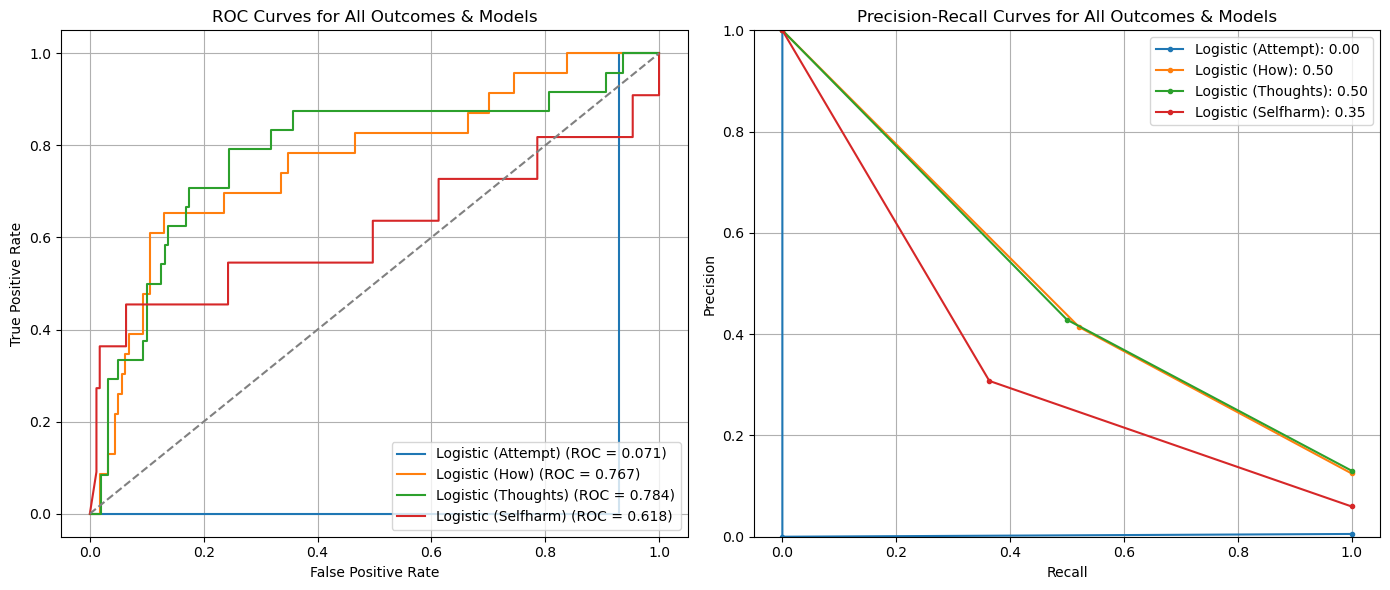

,Outcome,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1,PR Score
0,Attempt,Logistic,"{'C': 11.288378916846883, 'penalty': 'l2', 'so...",0.983696,0.071038,0.000000,0.000000,0.000000,0.002717
1,How,Logistic,"{'C': 3792.690190732246, 'penalty': 'l2', 'sol...",0.847826,0.766946,0.413793,0.521739,0.461538,0.497657
2,Thoughts,Logistic,"{'C': 29.763514416313132, 'penalty': 'l2', 'so...",0.847826,0.783854,0.428571,0.500000,0.461538,0.496894
3,Selfharm,Logistic,"{'C': 206.913808111479, 'penalty': 'l1', 'solv...",0.913043,0.617972,0.307692,0.363636,0.333333,0.354686


,Outcome,Model,Accuracy,ROC AUC,Precision,Recall,F1,PR AUC
0,Attempt,Logistic,0.996212,0.914387,1.000000,0.769231,0.869565,0.886509
1,How,Logistic,0.944444,0.886439,0.694444,0.694444,0.694444,0.708333
2,Thoughts,Logistic,0.920455,0.909723,0.693182,0.628866,0.659459,0.683751
3,Selfharm,Logistic,0.952020,0.897750,0.642857,0.775862,0.703125,0.717567


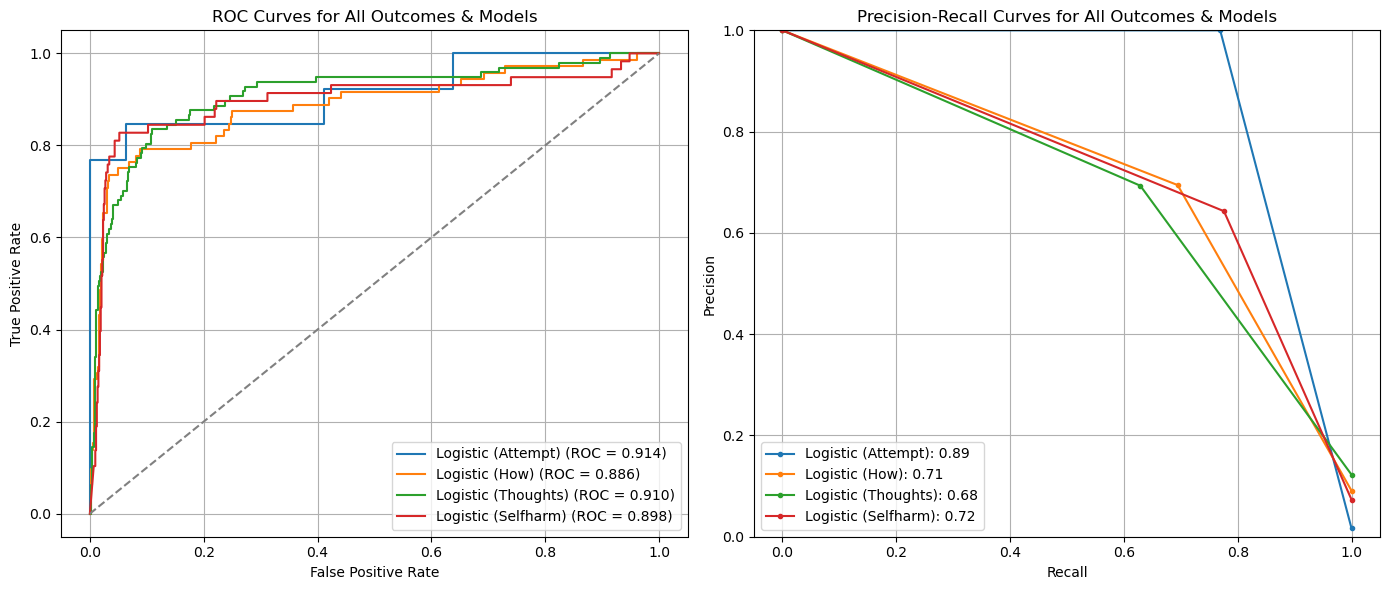

Logistic: {'C': 11.288378916846883, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic: {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic: {'C': 29.763514416313132, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic: {'C': 206.913808111479, 'penalty': 'l1', 'solver': 'liblinear'}


In [105]:
df = df_one_year
train_data, test_data = train_test_split(df, test_size=0.2, random_state=24)
outcome = ["Attempt", "How", "Thoughts", "Selfharm"]
pred_year = 1
qs = [
    # "psychotic", 
    "phq4", 
    "suicide", 
    "substance", 
    "help", 
    "identity"
]
encoded = "encoded"
interactions = False
model_params = models
prev = True

# Training and Validation
attempt_results, attempt_final_probs, trained_models = train_models(train_data, outcome, pred_year, qs, encoded, model_params, prev, interactions=interactions)
display(attempt_results)

# --------
# TESTING
# --------
final_stats = []
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
ax_roc, ax_pr = axes

for mod_key, trained_mod in trained_models.items():
    mod_name, outcome = mod_key.rsplit("_", 1)

    feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)
    X, y = df_2022_2023[feature_cols], df_2022_2023[target_col]

    # Classification
    y_pred = trained_mod.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, target_names=["no", "yes"], output_dict=True)
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)
    pr_score = auc(recall, precision)
    ax_pr.plot(recall, precision, marker='.', label=f'{mod_name} ({outcome}): {pr_score:.2f}')
    
    # Probabilities for ROC Curve
    y_pred_proba = trained_mod.predict_proba(X)[:, 1]
    roc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    ax_roc.plot(fpr, tpr, label=f"{mod_name} ({outcome}) (ROC = {roc_score:.3f})")
    
    # Store results
    final_stats.append({
        "Outcome": outcome,
        "Model": mod_name,
        "Accuracy": accuracy,
        "ROC AUC": roc_score,
        "Precision": report["yes"]["precision"],
        "Recall": report["yes"]["recall"],
        "F1": report["yes"]["f1-score"],
        "PR AUC": pr_score,
    })

# Display final test results
display(pd.DataFrame(final_stats))

# Finalizing the ROC subplot
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC Curves for All Outcomes & Models")
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# Finalizing the PR subplot
ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim(0, 1)
ax_pr.set_title("Precision-Recall Curves for All Outcomes & Models")
ax_pr.legend()
ax_pr.grid(True)

# Show both subplots
plt.tight_layout()
plt.show()

# Print best hyperparameters for each model
for name, params in zip(attempt_results["Model"], attempt_results["Best Params"]):
    print(f"{name}: {params}")


<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Variable Importance**

### **Question Category Ablation Tests**

In [207]:
# Imputing suicidality responses (classification and probability)

# Predicting current year responses using current year responses to non-suicidality questions
curr_imputation = {
    "ml": {
        "Attempt": ("RandomForest", RandomForestClassifier(random_state=42), {'max_depth': 20, 'n_estimators': 50}),
        "How": ("RandomForest", RandomForestClassifier(random_state=42), {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}),
        "Thoughts": ("RandomForest", RandomForestClassifier(random_state=42), {'max_depth': 20, 'n_estimators': 200}),
        "Selfharm": ("RandomForest", RandomForestClassifier(random_state=42), {'max_depth': None, 'n_estimators': 100}),
    },
    "parametric": {
        "Attempt": ("Logistic", LogisticRegression(random_state=42), {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'liblinear'}),
        "How": ("Logistic", LogisticRegression(random_state=42), {'C': 11.288378916846883, 'penalty': 'l2', 'solver': 'lbfgs'}),
        "Thoughts": ("Logistic", LogisticRegression(random_state=42), {'C': 0.615848211066026, 'penalty': 'l1', 'solver': 'liblinear'}),
        "Selfharm": ("Logistic", LogisticRegression(random_state=42), {'C': 78.47599703514607, 'penalty': 'l2', 'solver': 'lbfgs'}),
    },
}

# Predicting current year responses using current year responses to non-suicidality questions and previous year responses (including suicidality questions)
prev_imputation = {
     "ml": {
        "Attempt": ("LightGBM", LGBMClassifier(), {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}),
        "How": ("LightGBM", LGBMClassifier(), {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}),
        "Thoughts": ("LightGBM", LGBMClassifier(), {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}),
        "Selfharm": ("NeuralNet", MLPClassifier(), {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}),
     },
     "parametric": {
        "Attempt": ("Logistic", LogisticRegression(random_state=42), {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'liblinear'}),
        "How": ("Logistic", LogisticRegression(random_state=42), {'C': 21.54434690031882, 'penalty': 'l1', 'solver': 'liblinear'}),
        "Thoughts": ("Logistic", LogisticRegression(random_state=42), {'C': 1291.5496650148827, 'penalty': 'l2', 'solver': 'liblinear'}),
        "Selfharm": ("Logistic", LogisticRegression(random_state=42), {'C': 21.54434690031882, 'penalty': 'l1', 'solver': 'liblinear'}),
     }
}

In [210]:
def known_train_models(df, outcomes, pred_year, qs, encoded, model_type, best_params_dict, prev, interactions=False):
    print(f"Training models for {outcomes} using predefined hyperparameters.")

    outcome_results = []
    trained_models = {}

    # Create shared ROC and PR Curve subplots for all outcomes
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    ax_roc, ax_pr = axes

    for outcome in outcomes:
        print(f"Processing outcome: {outcome}")
        feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)

        # Filter out people who did not take the survey
        df_filtered = df[df[f"HasResponse{pred_year}"] == 1]
        if prev:
            df_filtered = df_filtered[df_filtered[f"HasResponse{pred_year-1}"] == 1]

        X, y = df_filtered[feature_cols], df_filtered[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Get interaction terms if enabled
        if interactions:
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
            X_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(feature_cols))
            X_test = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(feature_cols))

        # Convert to Pandas DataFrame for consistency
        X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
        y_train, y_test = pd.Series(y_train), pd.Series(y_test)
        final_probs = X_test.copy()
        final_probs[outcome] = y_test.values
    
        mod_name, mod, best_params = best_params_dict[model_type][outcome]
        print(f"Training best model {mod_name} for {outcome}.")

        # mod.set_params(**best_params)
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=["no", "yes"], output_dict=True)

        # PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        pr_score = auc(recall, precision)
        ax_pr.plot(recall, precision, marker='.', label=f'{mod_name} ({outcome}): {pr_score:.2f}')

        # ROC Curve
        y_pred_proba = mod.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        ax_roc.plot(fpr, tpr, label=f"{mod_name} ({outcome}) (ROC = {auc_score:.3f})")

        # Store results
        outcome_results.append({
            "Outcome": outcome,
            "Model": mod_name,
            "Best Params": mod.get_params(),
            "Accuracy": accuracy,
            "ROC AUC": auc_score,
            "Precision": report["yes"]["precision"],
            "Recall": report["yes"]["recall"],
            "F1": report["yes"]["f1-score"],
            "PR Score": pr_score,
        })

        trained_models[f"{mod_name}_{outcome}"] = mod
        print(f"{mod_name}_{outcome} - Trained with predefined params, PR AUC: {pr_score:.3f}")

    # Finalize ROC subplot
    ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("ROC Curves for All Outcomes & Models")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    # Finalize PR subplot
    ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  # Reference line
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_ylim(0, 1)
    ax_pr.set_title("Precision-Recall Curves for All Outcomes & Models")
    ax_pr.legend()
    ax_pr.grid(True)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(outcome_results), final_probs, trained_models


Training models for ['Attempt', 'How', 'Thoughts', 'Selfharm'] using predefined hyperparameters.
Processing outcome: Attempt
Training best model RandomForest for Attempt.
RandomForest_Attempt - Trained with predefined params, PR AUC: 0.532
Processing outcome: How
Training best model RandomForest for How.
RandomForest_How - Trained with predefined params, PR AUC: 0.587
Processing outcome: Thoughts
Training best model RandomForest for Thoughts.
RandomForest_Thoughts - Trained with predefined params, PR AUC: 0.585
Processing outcome: Selfharm
Training best model RandomForest for Selfharm.
RandomForest_Selfharm - Trained with predefined params, PR AUC: 0.572


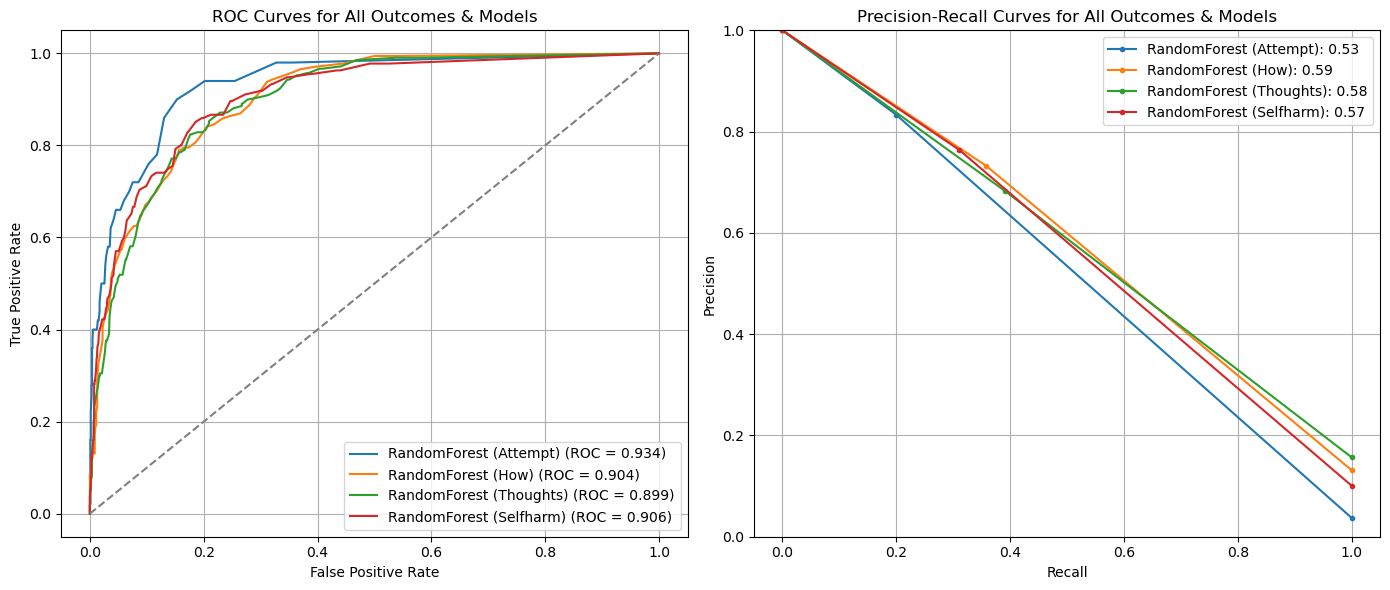

,Outcome,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1,PR Score
0,Attempt,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.968610,0.934371,0.833333,0.200000,0.322581,0.531614
1,How,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.898356,0.904106,0.732558,0.357955,0.480916,0.587484
2,Thoughts,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.875934,0.899352,0.683333,0.390476,0.496970,0.584737
3,Selfharm,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.920777,0.905705,0.763636,0.311111,0.442105,0.572127


,Outcome,Model,Accuracy,ROC AUC,Precision,Recall,F1,PR AUC
0,Attempt,RandomForest,0.994949,0.947171,0.909091,0.769231,0.833333,0.841055
1,How,RandomForest,0.969697,0.964410,0.944444,0.708333,0.809524,0.839646
2,Thoughts,RandomForest,0.958333,0.966565,0.890244,0.752577,0.815642,0.836562
3,Selfharm,RandomForest,0.973485,0.963286,0.974359,0.655172,0.783505,0.827392


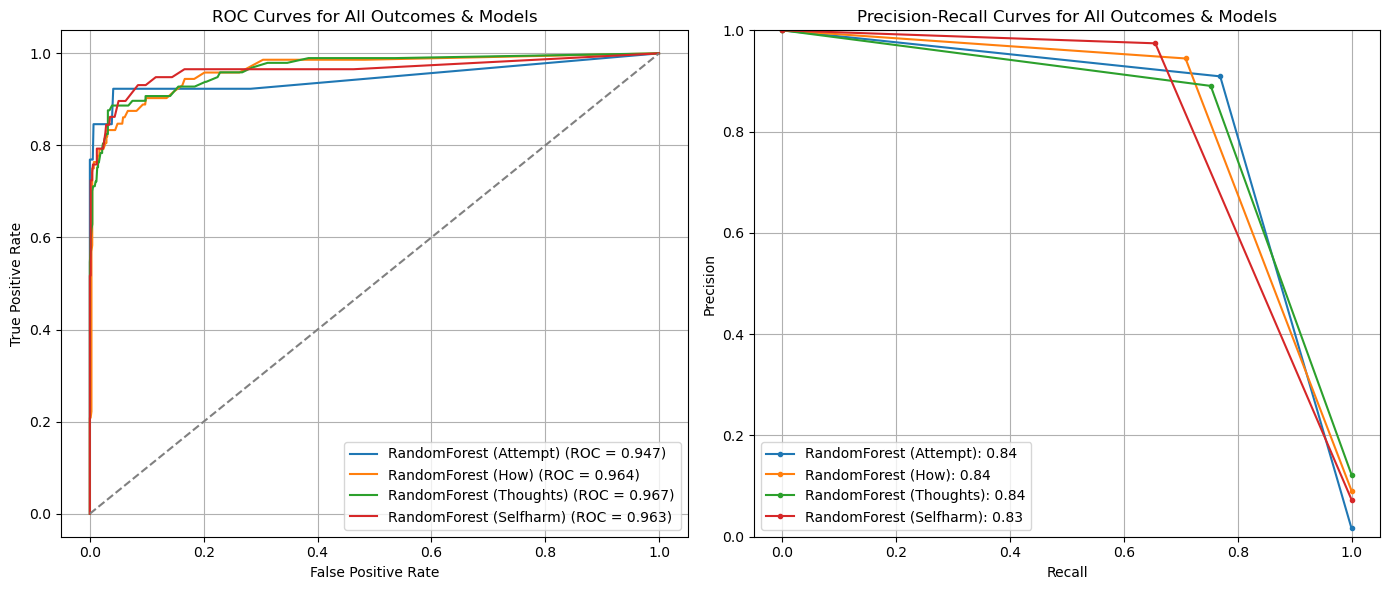

RandomForest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RandomForest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RandomForest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_l

In [211]:
df = df_curr
train_data, test_data = train_test_split(df, test_size=0.2, random_state=24)
outcome = ["Attempt", "How", "Thoughts", "Selfharm"]
pred_year = 1
qs = [
    "psychotic", 
    "phq4", 
    "suicide", 
    "substance", 
    "help", 
    "identity"
]
encoded = "encoded"
interactions = False
model_type = "ml"
prev = False
best_params_dict = curr_imputation

# Training and Validation
attempt_results, attempt_final_probs, trained_models = known_train_models(
    train_data, 
    outcome, 
    pred_year, 
    qs, 
    encoded, 
    model_type, 
    best_params_dict, 
    prev, 
    interactions=interactions
)
display(attempt_results)

# --------
# TESTING
# --------
final_stats = []
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
ax_roc, ax_pr = axes

for mod_key, trained_mod in trained_models.items():
    mod_name, outcome = mod_key.rsplit("_", 1)

    feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)
    X, y = df_2022_2023[feature_cols], df_2022_2023[target_col]

    # Classification
    y_pred = trained_mod.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, target_names=["no", "yes"], output_dict=True)
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)
    pr_score = auc(recall, precision)
    ax_pr.plot(recall, precision, marker='.', label=f'{mod_name} ({outcome}): {pr_score:.2f}')
    
    # Probabilities for ROC Curve
    y_pred_proba = trained_mod.predict_proba(X)[:, 1]
    roc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    ax_roc.plot(fpr, tpr, label=f"{mod_name} ({outcome}) (ROC = {roc_score:.3f})")
    
    # Store results
    final_stats.append({
        "Outcome": outcome,
        "Model": mod_name,
        "Accuracy": accuracy,
        "ROC AUC": roc_score,
        "Precision": report["yes"]["precision"],
        "Recall": report["yes"]["recall"],
        "F1": report["yes"]["f1-score"],
        "PR AUC": pr_score,
    })

# Display final test results
display(pd.DataFrame(final_stats))

# Finalizing the ROC subplot
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC Curves for All Outcomes & Models")
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# Finalizing the PR subplot
ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim(0, 1)
ax_pr.set_title("Precision-Recall Curves for All Outcomes & Models")
ax_pr.legend()
ax_pr.grid(True)

# Show both subplots
plt.tight_layout()
plt.show()

# Print best hyperparameters for each model
for name, params in zip(attempt_results["Model"], attempt_results["Best Params"]):
    print(f"{name}: {params}")


______

### **Permutation Importance**

In [ ]:
def plot_permutation_importance(importance_df, top_n=20):
    importance_df = importance_df.head(top_n)
    
    # Plot top n
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance Mean"], xerr=importance_df["Importance Std"], color='steelblue', alpha=0.8)
    plt.xlabel("Permutation Importance (Mean Decrease in Performance)")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Most Important Features (Permutation Importance)")
    plt.gca().invert_yaxis()  # Most important at the top
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Plot bottom n
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance Mean"], xerr=importance_df["Importance Std"], color='steelblue', alpha=0.8)
    plt.xlabel("Permutation Importance (Mean Decrease in Performance)")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Most Important Features (Permutation Importance)")
    plt.gca().invert_yaxis()  # Most important at the top
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.show()

In [192]:
def plot_cumulative_importance(importance_df, threshold=0.95):
    total_importance = importance_df["Importance Mean"].sum()
    importance_df["Normalized Importance"] = importance_df["Importance Mean"] / total_importance
    
    print("Total:", importance_df["Normalized Importance"].sum())
    
    importance_df["Cumulative Importance"] = np.cumsum(importance_df["Normalized Importance"])
    num_features = (importance_df["Cumulative Importance"] <= threshold).sum()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(importance_df) + 1), importance_df["Cumulative Importance"], marker='o', linestyle='-')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"{threshold*100:.0f}% Importance Threshold")
    plt.axvline(x=num_features, color='r', linestyle='--', label=f"{num_features} Features Needed")
    plt.xlabel("Number of Features")
    plt.ylabel("Cumulative Permutation Importance")
    plt.title("Cumulative Feature Importance")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Number of features needed to reach {threshold*100:.0f}% importance: {num_features}")
    return num_features

In [195]:
def print_permutation_importance(df, outcomes, pred_year, encoded, model_type, best_params_dict, n_repeats=10):
    for outcome in outcomes:
        feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)
        df_filtered = df[df[f"HasResponse{pred_year}"] == 1]
        if prev:
            df_filtered = df_filtered[df_filtered[f"HasResponse{pred_year-1}"] == 1]

        X, y = df_filtered[feature_cols], df_filtered[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Convert to Pandas DataFrame for consistency
        X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
        y_train, y_test = pd.Series(y_train), pd.Series(y_test)
        final_probs = X_test.copy()
        final_probs[outcome] = y_test.values

        mod_name, mod, best_params = best_params_dict[model_type][outcome]
        print(f"Training best model {mod_name} for {outcome}.")

        # Apply best parameters
        mod.set_params(**best_params)
        mod.fit(X_train, y_train)

        result = permutation_importance(
            mod, X_test, y_test, n_repeats=n_repeats, random_state=42, scoring="roc_auc"
        )

        importance_df = pd.DataFrame({
            "Feature": feature_cols,
            "Importance Mean": result.importances_mean,
            "Importance Std": result.importances_std
        })

        importance_df = importance_df.sort_values(by="Importance Mean", ascending=False)
        plot_permutation_importance(importance_df)
        num_features = plot_cumulative_importance(importance_df)
        print("\nPermutation Importance (Sorted):")
        print(importance_df.head(num_features).to_string(index=False))

Training best model RandomForest for Attempt.


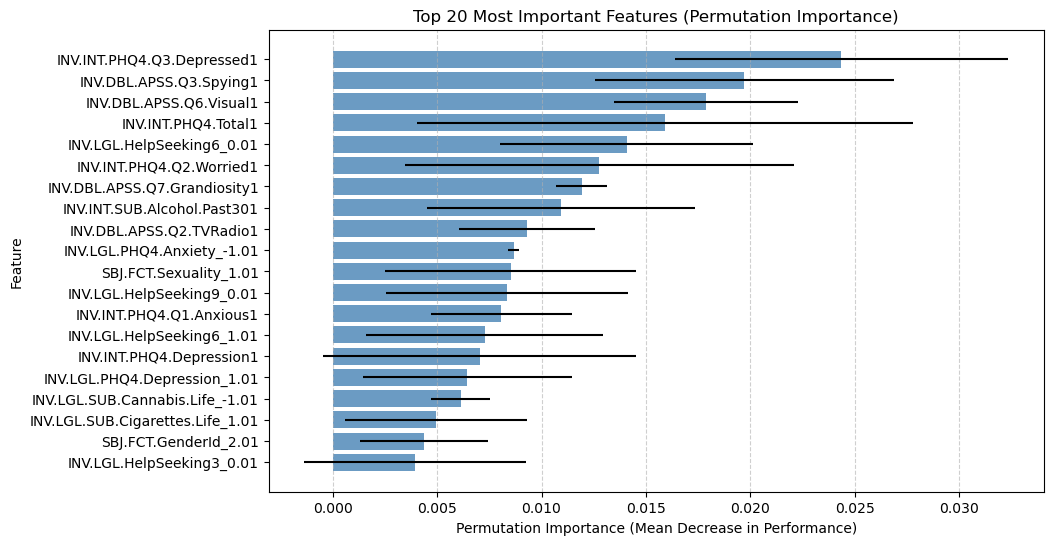

Total: 0.9999999999999996


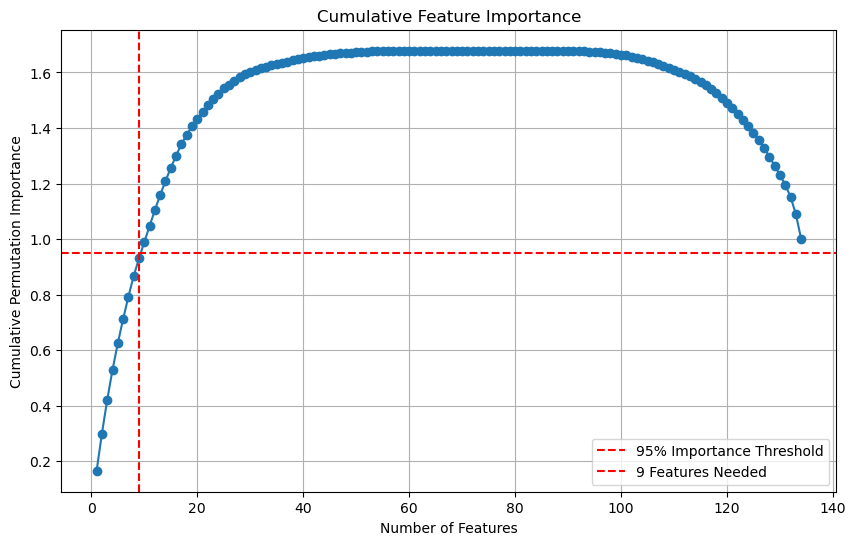

Number of features needed to reach 95% importance: 9

Permutation Importance (Sorted):
                     Feature  Importance Mean  Importance Std  Normalized Importance  Cumulative Importance
  INV.INT.PHQ4.Q3.Depressed1         0.024361        0.007992               0.165647               0.165647
     INV.DBL.APSS.Q3.Spying1         0.019708        0.007154               0.134008               0.299654
     INV.DBL.APSS.Q6.Visual1         0.017871        0.004393               0.121516               0.421171
         INV.INT.PHQ4.Total1         0.015907        0.011862               0.108163               0.529333
   INV.LGL.HelpSeeking6_0.01         0.014071        0.006056               0.095681               0.625015
    INV.INT.PHQ4.Q2.Worried1         0.012772        0.009332               0.086844               0.711859
INV.DBL.APSS.Q7.Grandiosity1         0.011928        0.001227               0.081109               0.792968
 INV.INT.SUB.Alcohol.Past301         0.010927    

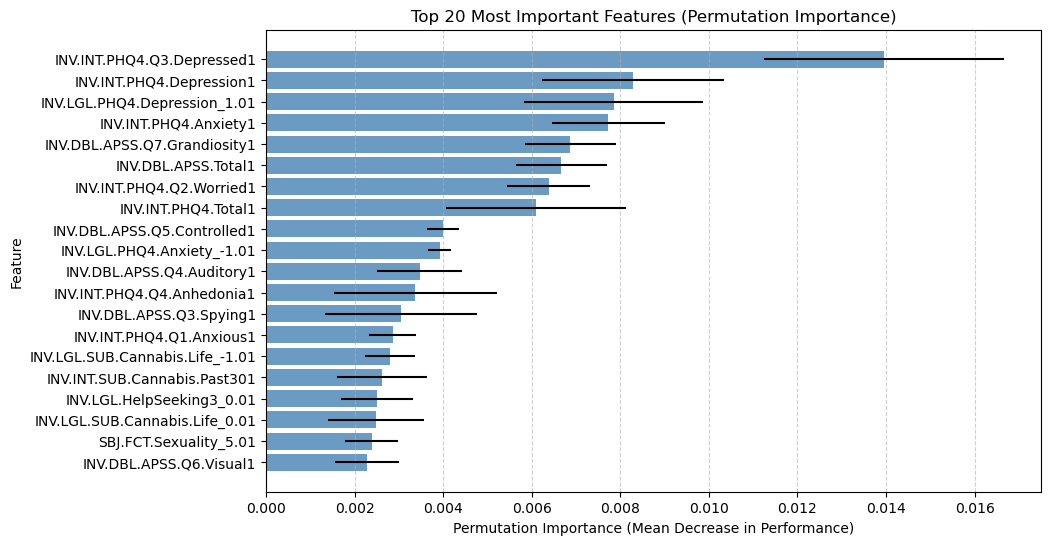

Total: 1.0000000000000002


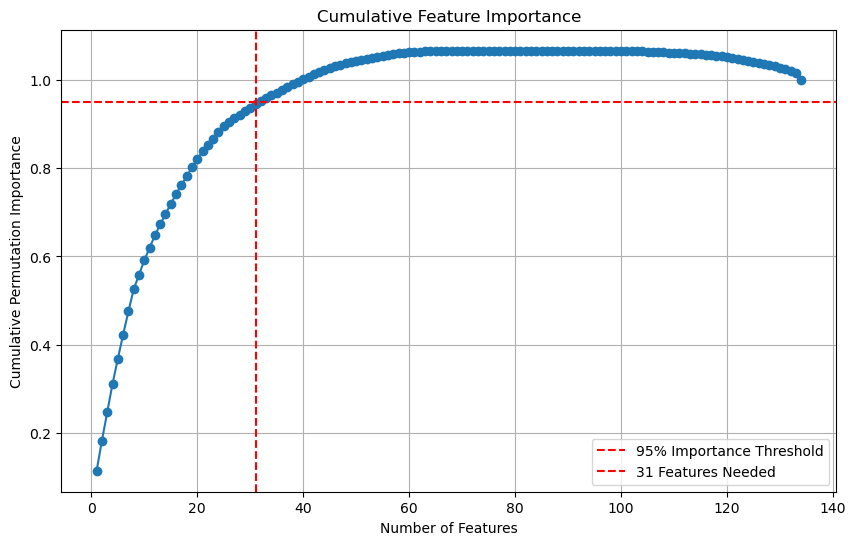

Number of features needed to reach 95% importance: 31

Permutation Importance (Sorted):
                        Feature  Importance Mean  Importance Std  Normalized Importance  Cumulative Importance
     INV.INT.PHQ4.Q3.Depressed1         0.013959        0.002711               0.115022               0.115022
       INV.INT.PHQ4.Depression1         0.008281        0.002053               0.068232               0.183254
   INV.LGL.PHQ4.Depression_1.01         0.007846        0.002020               0.064649               0.247903
          INV.INT.PHQ4.Anxiety1         0.007729        0.001276               0.063689               0.311592
   INV.DBL.APSS.Q7.Grandiosity1         0.006868        0.001029               0.056588               0.368180
            INV.DBL.APSS.Total1         0.006669        0.001034               0.054951               0.423131
       INV.INT.PHQ4.Q2.Worried1         0.006382        0.000932               0.052583               0.475714
            INV.INT.PHQ4

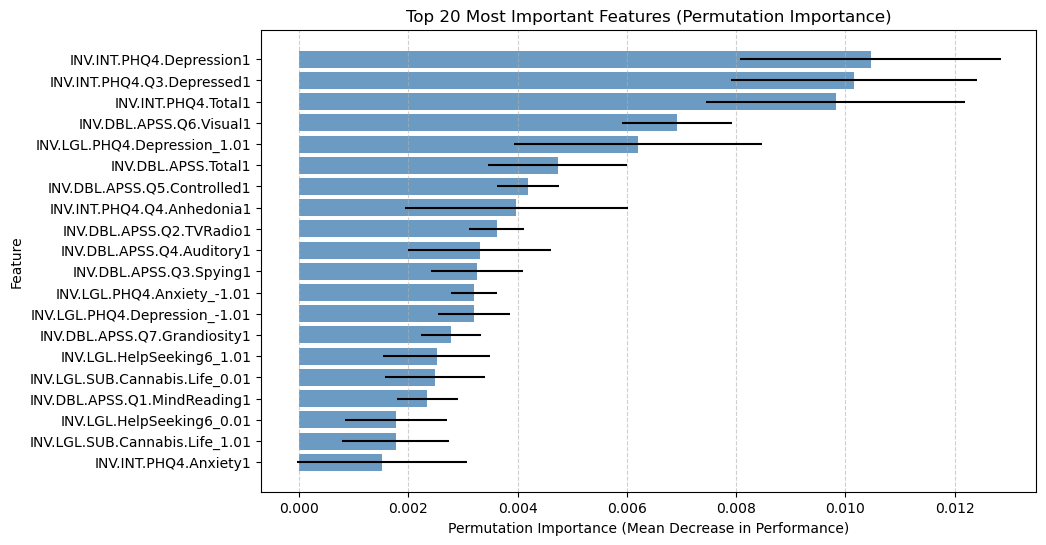

Total: 1.0000000000000002


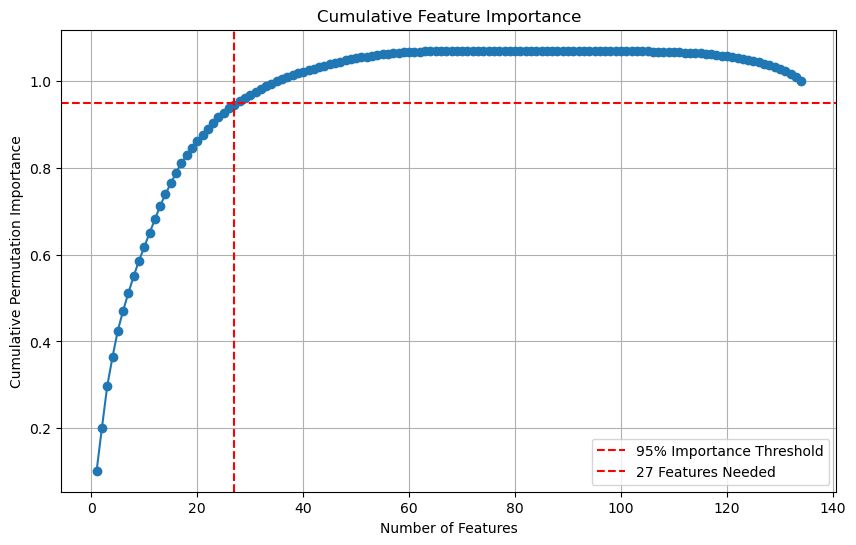

Number of features needed to reach 95% importance: 27

Permutation Importance (Sorted):
                        Feature  Importance Mean  Importance Std  Normalized Importance  Cumulative Importance
       INV.INT.PHQ4.Depression1         0.010462        0.002386               0.102044               0.102044
     INV.INT.PHQ4.Q3.Depressed1         0.010154        0.002252               0.099038               0.201082
            INV.INT.PHQ4.Total1         0.009820        0.002376               0.095785               0.296868
        INV.DBL.APSS.Q6.Visual1         0.006919        0.001012               0.067486               0.364353
   INV.LGL.PHQ4.Depression_1.01         0.006200        0.002269               0.060476               0.424830
            INV.DBL.APSS.Total1         0.004738        0.001273               0.046212               0.471042
    INV.DBL.APSS.Q5.Controlled1         0.004191        0.000563               0.040877               0.511919
     INV.INT.PHQ4.Q4.Anh

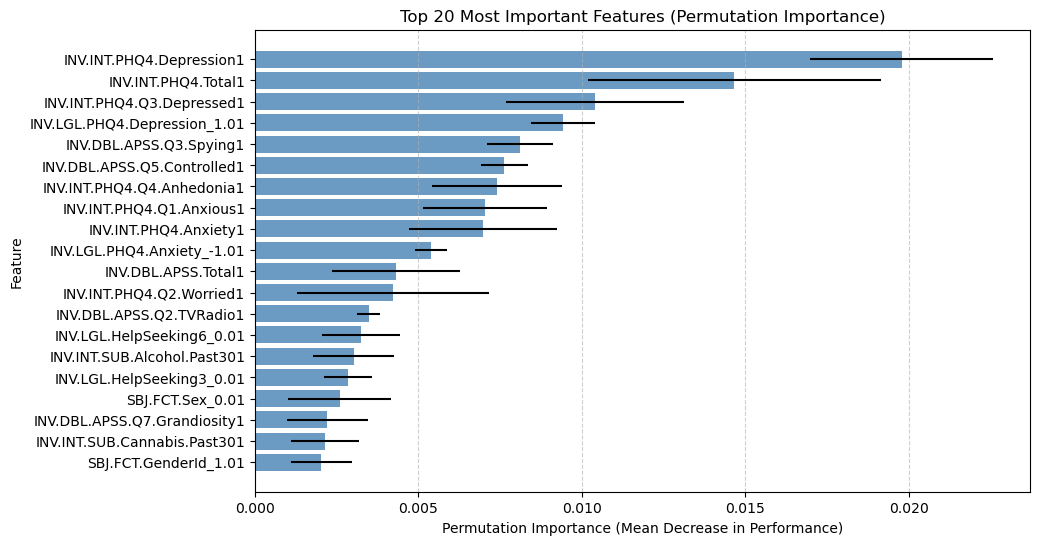

Total: 1.0


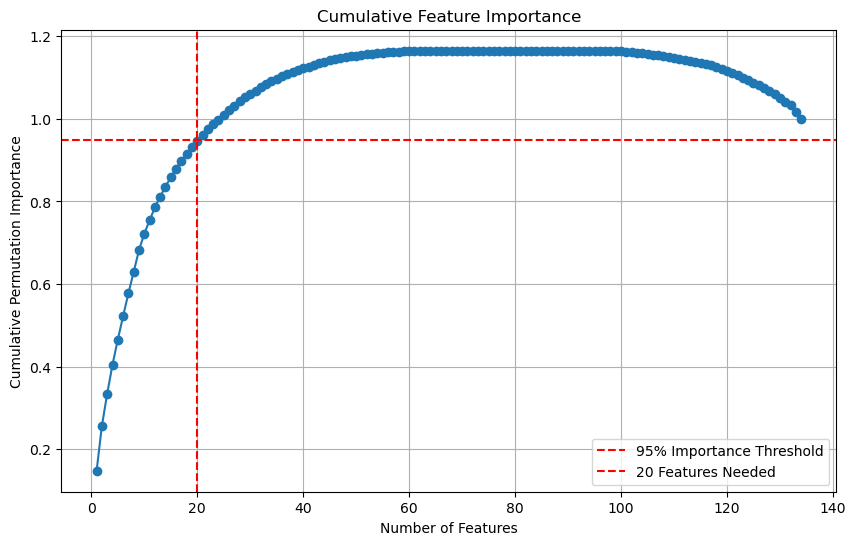

Number of features needed to reach 95% importance: 20

Permutation Importance (Sorted):
                     Feature  Importance Mean  Importance Std  Normalized Importance  Cumulative Importance
    INV.INT.PHQ4.Depression1         0.019788        0.002794               0.147605               0.147605
         INV.INT.PHQ4.Total1         0.014665        0.004488               0.109390               0.256995
  INV.INT.PHQ4.Q3.Depressed1         0.010403        0.002719               0.077598               0.334593
INV.LGL.PHQ4.Depression_1.01         0.009414        0.000977               0.070223               0.404816
     INV.DBL.APSS.Q3.Spying1         0.008112        0.000998               0.060509               0.465326
 INV.DBL.APSS.Q5.Controlled1         0.007628        0.000724               0.056901               0.522226
  INV.INT.PHQ4.Q4.Anhedonia1         0.007402        0.001985               0.055215               0.577441
    INV.INT.PHQ4.Q1.Anxious1         0.007047   

In [196]:
df = df_curr
train_data, test_data = train_test_split(df, test_size=0.2, random_state=24)
outcomes = ["Attempt", "How", "Thoughts", "Selfharm"]
pred_year = 1
qs = [
    "psychotic", 
    "phq4", 
    "suicide", 
    "substance", 
    "help", 
    "identity"
]
encoded = "encoded"
interactions = False
model_type = "ml"
prev = False
best_params_dict = curr_imputation

print_permutation_importance(df, outcomes, pred_year, encoded, model_type, best_params_dict)

_______

## **Confounding Variables**

In [144]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [145]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    print("\n🔍 Variance Inflation Factor (VIF) Scores:")
    print(vif_data.sort_values(by="VIF", ascending=False))

    return vif_data[vif_data["VIF"] > 5]

In [159]:
feature_cols, target_col = get_cols(1, "Attempt", ["psychotic", "substance", "suicide", "phq4", "help", "identity"], "encoded", False)

In [ ]:
high_vif_features = calculate_vif(df_curr[feature_cols])


🔍 Variance Inflation Factor (VIF) Scores:
                                            Feature           VIF
109                          SBJ.FCT.GenderId_10.01  5.440401e+09
112                           SBJ.FCT.GenderId_6.01  5.188102e+09
98                           SBJ.FCT.GenderId_-1.01  4.403084e+09
129                           SBJ.FCT.GenderId_7.01  4.137811e+09
133       SBJ.LGL.Race.HawaiianPacificIslander_1.01  4.033965e+09
..                                              ...           ...
107                     SBJ.LGL.Race.Multiple_-1.01           NaN
116  SBJ.LGL.Race.HaitianBlackAfricanAmerican_-1.01           NaN
118                        SBJ.LGL.Race.White_-1.01           NaN
124                        SBJ.LGL.Race.Asian_-1.01           NaN
126    SBJ.LGL.Race.MiddleEasternNorthAfrican_-1.01           NaN

[134 rows x 2 columns]


In [165]:
high_vif_features

,Feature,VIF
0,INV.DBL.APSS.Q7.Grandiosity1,8.968874e+00
1,INV.DBL.APSS.Q5.Controlled1,1.109463e+01
2,INV.DBL.APSS.Q3.Spying1,6.556755e+00
3,INV.DBL.APSS.Q1.MindReading1,6.025039e+00
4,INV.DBL.APSS.Total1,6.371062e+00
...,...,...
129,SBJ.FCT.GenderId_7.01,4.137811e+09
130,SBJ.LGL.Race.White_1.01,7.691684e+03
131,SBJ.LGL.Race.Asian_0.01,3.802171e+03
132,SBJ.FCT.Sex_1.01,1.196466e+05


_______

## **Logistic Regression Stepwise Feature Selection**

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [141]:
def stepwise_logistic_regression(X, y, method="both", scoring="recall", forward=True, floating=False):
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=500)
    if method == "forward":
        forward = True
        floating = False
    elif method == "backward":
        forward = False
        floating = False
    elif method == "both":
        forward = True
        floating = True

    # Perform stepwise feature selection
    sfs = SFS(
        log_reg,
        k_features="best",
        forward=forward,
        floating=floating,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )
    sfs.fit(X, y)
    selected_features = list(sfs.k_feature_names_)
    log_reg.fit(X[selected_features], y)

    print("\nFinal Selected Features:", selected_features)
    
    return selected_features, log_reg

In [ ]:
df = df_curr
train_data, test_data = train_test_split(df, test_size=0.2, random_state=24)
outcomes = ["Attempt", "How", "Thoughts", "Selfharm"]
pred_year = 1
qs = [
    "psychotic", 
    "phq4", 
    "suicide", 
    "substance", 
    "help", 
    "identity"
]
encoded = "encoded"
interactions = False
model_type = "ml"
prev = False
best_params_dict = curr_imputation

stepwise_logistic_regression()

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Final Compounding Model**

In [216]:
qs = [
    "psychotic", 
    "phq4", 
    "suicide", 
    "substance", 
    "help", 
    "identity"
]

In [218]:
def train_best_model(df, outcome, pred_year, qs, prev, mod, best_params):
    feature_cols, target_col = get_cols(pred_year, outcome, qs, "encoded", prev)

    df_filtered = df[df[f"HasResponse{pred_year}"] == 1]
    if prev:
        df_filtered = df_filtered[df_filtered[f"HasResponse{pred_year-1}"] == 1]

    X, y = df_filtered[feature_cols], df_filtered[target_col]
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    
    mod.set_params(**best_params)
    mod.fit(X_train, y_train)

    return mod

**Best Imputation Models**

In [222]:
curr_imputation = {
    "ml": {
        "Attempt": ("RandomForest", train_best_model(df_curr, "Attempt", 1, qs, False, RandomForestClassifier(random_state=42), {'max_depth': 20, 'n_estimators': 50})),
        "How": ("RandomForest", train_best_model(df_curr, "How", 1, qs, False, RandomForestClassifier(random_state=42), {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100})),
        "Thoughts": ("RandomForest", train_best_model(df_curr, "Thoughts", 1, qs, False, RandomForestClassifier(random_state=42), {'max_depth': 20, 'n_estimators': 200})),
        "Selfharm": ("RandomForest", train_best_model(df_curr, "Selfharm", 1, qs, False, RandomForestClassifier(random_state=42), {'max_depth': None, 'n_estimators': 100}))
    },
    "parametric": {
        "Attempt": ("Logistic", train_best_model(df_curr, "Attempt", 1, qs, False, LogisticRegression(random_state=42), {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'liblinear'})),
        "How": ("Logistic", train_best_model(df_curr, "How", 1, qs, False, LogisticRegression(random_state=42), {'C': 11.288378916846883, 'penalty': 'l2', 'solver': 'lbfgs'})),
        "Thoughts": ("Logistic", train_best_model(df_curr, "Thoughts", 1, qs, False, LogisticRegression(random_state=42), {'C': 0.615848211066026, 'penalty': 'l1', 'solver': 'liblinear'})),
        "Selfharm": ("Logistic", train_best_model(df_curr, "Selfharm", 1, qs, False, LogisticRegression(random_state=42), {'C': 78.47599703514607, 'penalty': 'l2', 'solver': 'lbfgs'})),
    },
}

curr_imputation = {
    "ml": {
        "Attempt": ("LightGBM", train_best_model(df_one_year, "Attempt", 1, qs, True, LGBMClassifier(random_state=42), {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20})),
        "How": ("LightGBM", train_best_model(df_one_year, "How", 1, qs, True, LGBMClassifier(random_state=42), {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31})),
        "Thoughts": ("LightGBM", train_best_model(df_one_year, "Thoughts", 1, qs, True, LGBMClassifier(random_state=42), {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20})),
        "Selfharm": ("NeuralNet", train_best_model(df_one_year, "Selfharm", 1, qs, True, MLPClassifier(random_state=42), {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}))
    },
    "parametric": {
        "Attempt": ("Logistic", train_best_model(df_one_year, "Attempt", 1, qs, True, LogisticRegression(random_state=42), {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'liblinear'})),
        "How": ("Logistic", train_best_model(df_one_year, "How", 1, qs, True, LogisticRegression(random_state=42), {'C': 21.54434690031882, 'penalty': 'l1', 'solver': 'liblinear'})),
        "Thoughts": ("Logistic", train_best_model(df_one_year, "Thoughts", 1, qs, True, LogisticRegression(random_state=42), {'C': 1291.5496650148827, 'penalty': 'l2', 'solver': 'liblinear'})),
        "Selfharm": ("Logistic", train_best_model(df_one_year, "Selfharm", 1, qs, True, LogisticRegression(random_state=42), {'C': 21.54434690031882, 'penalty': 'l1', 'solver': 'liblinear'})),
    },
}

[LightGBM] [Info] Number of positive: 15, number of negative: 905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016304 -> initscore=-4.099885
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 93, number of negative: 827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the tr

In [213]:
outcomes = ["Attempt", "How", "Thoughts", "Selfharm"]

**Imputing 2020 Suicidality Responses**

Presumably, the input is a dataframe with responses from 2020. We want to use the non-suicidality questions from that same year to impute the suicidality questions and probabilities using the best trained models.

In [ ]:
def impute_same_year_class_and_prob(df, pred_year, feature_cols):
    df = df[df[f"HasResponse{pred_year}"] == 1]
    
    for outcome in outcomes:
        print(f"Predicting {outcome} with {mod_name}...")
        mod_name, best_mod = curr_imputation[outcome]
        X = df[feature_cols]
        y_pred = best_mod.predict(X)
        y_pred_proba = best_mod.predict_proba(X)[:, 1]
        
        if pred_year in [2020, 2021]:
            df[f"INV.INT.SI.{outcome}_1.0{pred_year}"] = y_pred
        df[f"INV.INT.SI.{outcome}.Prob_1.0{pred_year}"] = y_pred_proba
        
    return df

**Imputing Subsequent Suicidality Responses**

Presumably, the input is a dataframe with responses from 2020. We want to use the non-suicidality questions from that same year to impute the suicidality questions and probabilities using the best trained models.

In [ ]:
def impute_prev_year_class_and_prob(df, pred_year, feature_cols):
    df = df[df[f"HasResponse{pred_year}"] == 1]
    df = df[df[f"HasResponse{pred_year-1}"] == 1]
    
    for outcome in outcomes:
        print(f"Predicting {outcome} with {mod_name}...")
        mod_name, best_mod = prev_imputation[outcome]
        X = df[feature_cols]
        y_pred = best_mod.predict(X)
        y_pred_proba = best_mod.predict_proba(X)[:, 1]
        
        if pred_year in [2020, 2021]:
            df[f"INV.INT.SI.{outcome}_1.0{pred_year}"] = y_pred
        df[f"INV.INT.SI.{outcome}.Prob_1.0{pred_year}"] = y_pred_proba
        
    return df

### **Compounding Imputation Model**

In [ ]:
class CompoundingImputationModel:
    def __init__(self, df, start_year, end_year, qs, encoded, non_si_years):
        self.df = df.copy()
        self.start_year = start_year
        self.end_year = end_year
        self.qs = qs
        self.encoded = encoded
        self.non_si_years = non_si_years

    def get_cols(self, y_year, outcome, prev):
        target_col = f"INV.INT.SI.{outcome}_1.0{y_year}" if self.encoded == "encoded" else f"INV.INT.SI.{outcome}{y_year}"
        
        feature_cols = []
        for q in self.qs:
            if q != "suicide":
                feature_cols += get_yearly_columns(cats[self.encoded][q], [y_year])
            if prev:
                feature_cols += get_yearly_columns(cats[self.encoded][q], [y_year - 1])
        
        return feature_cols, target_col

    def impute_same_year(self, pred_year):
        df = self.df[self.df[f"HasResponse{pred_year}"] == 1]

        for outcome in outcomes:
            print(f"Predicting {outcome} for {pred_year} using same-year model")
            
            _, best_mod = curr_imputation[outcome]
            X = df[self.get_cols(pred_year, outcome, prev=False)[0]]
            y_pred = best_mod.predict(X)
            y_pred_proba = best_mod.predict_proba(X)[:, 1]

            if pred_year in self.non_si_years:
                df[f"INV.INT.SI.{outcome}_1.0{pred_year}"] = y_pred
            df[f"INV.INT.SI.{outcome}.Prob_1.0{pred_year}"] = y_pred_proba
        
        self.df.update(df)
        return self.df

    def impute_prev_year(self, pred_year):
        df = self.df[(self.df[f"HasResponse{pred_year}"] == 1) & (self.df[f"HasResponse{pred_year - 1}"] == 1)]

        for outcome in outcomes:
            print(f"Predicting {outcome} for {pred_year} using previous-year model")
            _, best_mod = prev_imputation[outcome]
            X = df[self.get_cols(pred_year, outcome, prev=True)[0]]
            y_pred = best_mod.predict(X)
            y_pred_proba = best_mod.predict_proba(X)[:, 1]

            if pred_year in self.non_si_years:
                df[f"INV.INT.SI.{outcome}_1.0{pred_year}"] = y_pred
            df[f"INV.INT.SI.{outcome}.Prob_1.0{pred_year}"] = y_pred_proba
        
        self.df.update(df)
        return self.df

    def prepare_yearly_data(self, year):
        df_yearly = self.df[self.df[f"HasResponse{year}"] == 1]
        df_yearly = df_yearly.filter(regex=fr".*({year})$", axis=1)

        df_yearly.rename(columns=lambda col: re.sub(fr"{year}$", "1", col), inplace=True)
        return df_yearly

    def run_pipeline(self):
        print("\n**Starting Compounding Imputation Model...**")

        for year in range(self.start_year, self.end_year):
            print(f"\n**Processing Year: {year} -> Predicting {year + 1}**")

            self.df = self.impute_same_year(year)
            self.df = self.impute_prev_year(year)
            if year < self.end_year - 1:
                df_next = self.prepare_yearly_data(year + 1)
                self.df = pd.concat([self.df, df_next], ignore_index=True)

        print("\n**Final Compounded Model Completed**")
        return self.df

In [ ]:
# `encoded` should be a string: "regular" or "encoded"
def get_cols(y_year, outcome, qs, encoded, prev):
    target_col= f"INV.INT.SI.{outcome}_1.0{y_year}" if encoded == "encoded" else f"INV.INT.SI.{outcome}{y_year}"
    
    feature_cols = []
    for q in qs:
        if q != "suicide":
            feature_cols += get_yearly_columns(cats[encoded][q], [y_year])
        if prev:
            feature_cols += get_yearly_columns(cats[encoded][q], [y_year-1])
    
    return feature_cols, target_col

# Just previous year and curr year
def year_one_prediction_data(df, pred_year):
    df = df[df[f"HasResponse{pred_year}"] == 1]
    df = df[df[f"HasResponse{pred_year + 1}"] == 1]
    
    df = df.filter(regex=fr".*({pred_year}|{pred_year + 1})$", axis=1)
    
    df.rename(columns=lambda col: re.sub(fr"{pred_year}$", "0", col), inplace=True)
    df.rename(columns=lambda col: re.sub(fr"{pred_year + 1}$", "1", col), inplace=True)
    
    return df

# Training data for prev_imputation models
df_2022_2023 = year_one_prediction_data(encoded23, 2022)
df_2021_2022 = year_one_prediction_data(encoded23, 2021)
df_one_year  = pd.concat([df_2022_2023,df_2021_2022],ignore_index=True)

def curr_year_prediction_data(df, curr_year):
    df = df[df[f"HasResponse{curr_year}"] == 1]
    df = df.filter(regex=fr".*({curr_year})$", axis=1)
    df.rename(columns=lambda col: re.sub(fr"{curr_year}$", "1", col), inplace=True)
    return df

# Training data for curr_imputation models
df_2022 = curr_year_prediction_data(encoded23, 2022)
df_2023 = curr_year_prediction_data(encoded23, 2023)
df_curr  = pd.concat([df_2022, df_2023], ignore_index=True)

End of notebook :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>